In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
def load_data(N,difftemp,P,temp,nSteps,dt,last = True):
    if last:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
    else:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
def load_original_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [113]:
Tmin = 2.27
Tmax = 2.65
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)

L = 10
N = L**2
P = 100000
difftemp = 2
nSteps = 300
dt = 0.02

In [114]:
x_recon = np.empty((meas,P,N))
for i,T in enumerate(Ts):
    x_recon[i] = load_data(N,difftemp,P,T,nSteps,dt)
x_true = np.empty((meas,200000,N))
for i,T in enumerate(Ts):
    x_true[i] = load_original_data(L,T,200000)

(array([0.        , 0.01451739, 0.16950652, 0.47943913, 0.53673261,
        0.69195   , 0.57197609, 0.66551739, 0.54152609, 0.62899565,
        0.52006957, 0.63661957, 0.53965435, 0.66935217, 0.56403261,
        0.68505652, 0.53883261, 0.48802174, 0.17238261, 0.01625217,
        0.        ]),
 array([-1.15      , -1.04047619, -0.93095238, -0.82142857, -0.71190476,
        -0.60238095, -0.49285714, -0.38333333, -0.27380952, -0.16428571,
        -0.0547619 ,  0.0547619 ,  0.16428571,  0.27380952,  0.38333333,
         0.49285714,  0.60238095,  0.71190476,  0.82142857,  0.93095238,
         1.04047619,  1.15      ]),
 <BarContainer object of 21 artists>)

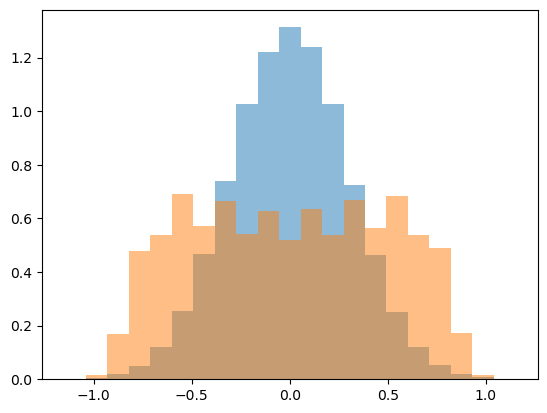

In [116]:
plt.hist(np.mean(x_recon[-1],axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True)
plt.hist(np.mean(x_true[-1],axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True)


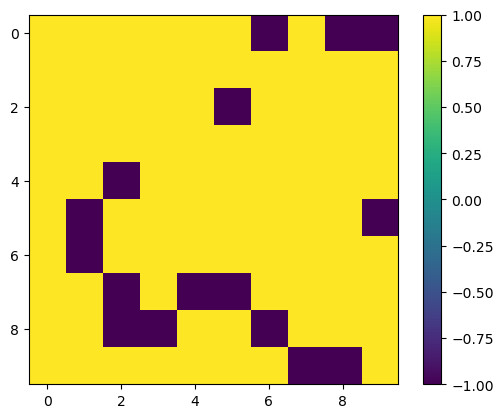

In [117]:
plt.imshow(np.sign(x_recon[0][0]).reshape(L,L))
plt.colorbar()

In [5]:
from scipy.ndimage import label

def find_clusters(lattice):
    labeled_array, num_features = label(lattice == 1)
    return labeled_array, num_features

def calculate_mean_cluster_size(labeled_array, num_features):
    cluster_sizes = []
    for label_value in range(1, num_features + 1):
        cluster_size = np.sum(labeled_array == label_value)
        cluster_sizes.append(cluster_size)
    if cluster_sizes:
        return np.mean(cluster_sizes)
    else:
        return 0

In [8]:
labeled_array, num_features = find_clusters(np.sign(x_recon[0][1]).reshape(L,L))

mean_cluster_size = calculate_mean_cluster_size(labeled_array, num_features)
print("Mean Cluster Size:", mean_cluster_size)


Mean Cluster Size: 2.4615384615384617


In [9]:
sumcluster = np.zeros(len(Ts))
for t,T in enumerate(Ts):
    for i in range(P):
        labeled_array, num_features = find_clusters(np.sign(x_recon[t][i]).reshape(L,L))
        mean_cluster_size = calculate_mean_cluster_size(labeled_array, num_features)
        sumcluster[t]+=mean_cluster_size
    sumcluster[t]/=P

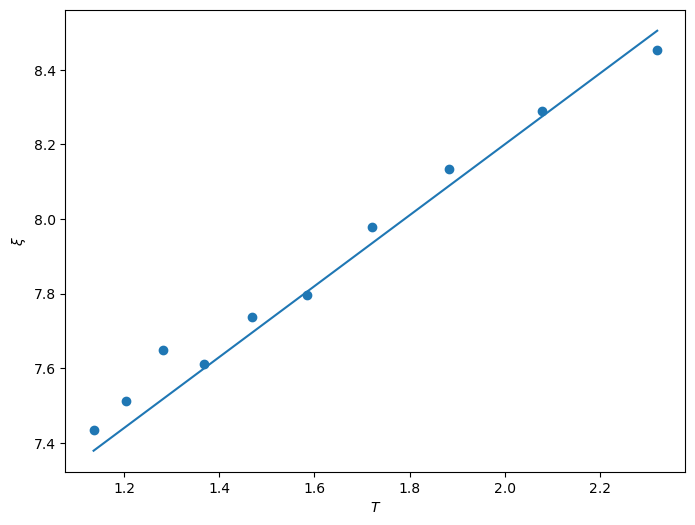

In [24]:
Tc = 2/np.log(1+np.sqrt(2))
plt.figure(figsize = (8,6))
plt.scatter((Ts-Tc)**-1,sumcluster)
plt.xlabel(r"$T$")
plt.ylabel(r"$\xi$")
plt.plot((Ts-Tc)**-1,0.95*(Ts-Tc)**-1 + 6.3)
#plt.xscale("log")
#plt.yscale("log")

In [48]:
sumcluster_true = np.zeros(len(Ts))
for t,T in enumerate(Ts):
    for i in range(200000):
        labeled_array, num_features = find_clusters(x_true[t][i].reshape(L,L))
        mean_cluster_size = calculate_mean_cluster_size(labeled_array, num_features)
        sumcluster_true[t]+=mean_cluster_size
    sumcluster_true[t]/=200000

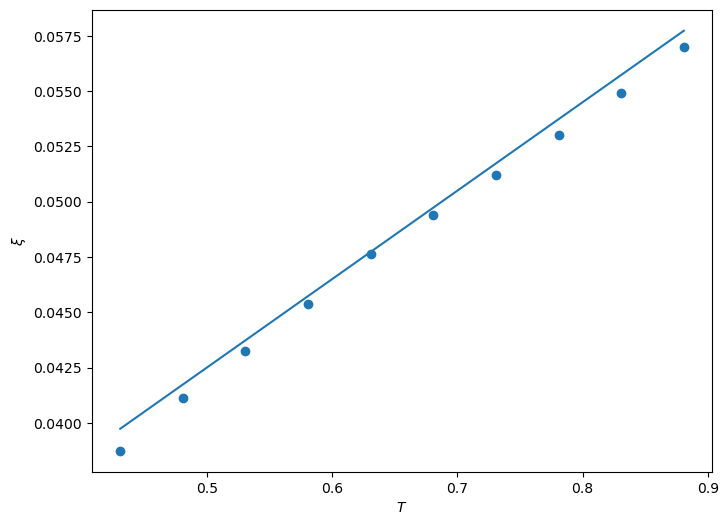

In [47]:
Tc = 2/np.log(1+np.sqrt(2))
plt.figure(figsize = (8,6))
plt.scatter((Ts-Tc),sumcluster**-1)
plt.xlabel(r"$T$")
plt.ylabel(r"$\xi$")
plt.plot((Ts-Tc),0.04*(Ts-Tc)+0.0225)
#plt.xscale("log")
#plt.yscale("log")

In [118]:
def get_energy(data):
    en = np.zeros(data.shape[0])
    N = data.shape[1]
    L = int(np.sqrt(N))
    #print(f"N = {N}, L = {L}")
    for i in range(2):
        
        nn = i +1
        if nn >= N:
            nn -= N
        nnsum = data[:,nn]

        nn = i -1
        if nn <0:
            nn += N
        nnsum += data[:,nn]

        nn = i +L
        if nn >= N:
            nn -= N
        nnsum += data[:,nn]

        nn = i -L
        if nn <0:
            nn += N
        nnsum += data[:,nn]
        #print(nnsum)
        en -= data[:,i]*nnsum
        
    return en/(2*N)

In [119]:
cap_true = np.zeros(len(Ts))
cap_recon = np.zeros(len(Ts))
for t,T in enumerate(Ts):
    en = get_energy(x_true[t])
    cap_true[t] = (np.mean(en**2) - np.mean(en)**2)/T**2
    en = get_energy(np.sign(x_recon[t]))
    cap_recon[t] = (np.mean(en**2) - np.mean(en)**2)/T**2

susc_true = np.zeros(len(Ts))
susc_recon = np.zeros(len(Ts))
for t,T in enumerate(Ts):
    magn = np.mean(x_true[t],axis = 1)
    susc_true[t] = (np.mean(magn**2) - np.mean(magn)**2)/T**2
    magn = np.mean(x_recon[t],axis = 1)
    susc_recon[t] = (np.mean(magn**2) - np.mean(magn)**2)/T**2


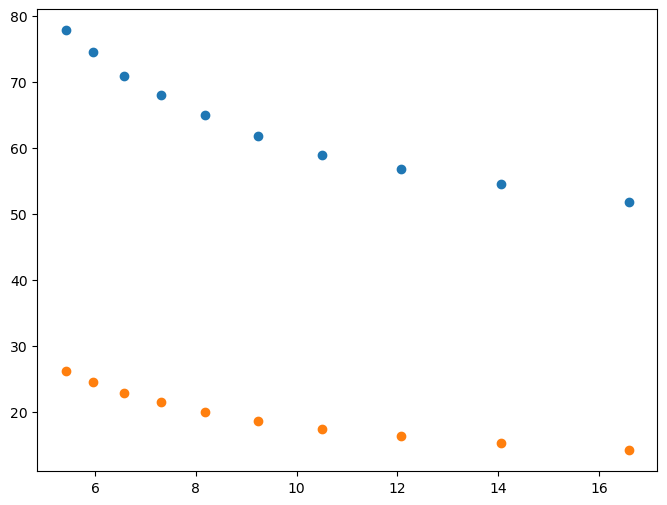

In [132]:
from scipy.optimize import curve_fit as cf
def lin(x,a,b):
    return a*x+b
#popt1, pcov = cf(lin,(Ts[5:]-Tc)**(-7/4),susc_recon[5:])
#popt2, pcov = cf(lin,(Ts[5:]-Tc)**(-7/4),susc_true[5:])
plt.figure(figsize = (8,6))
plt.scatter((Ts[10:]-Tc)**(-7/4),susc_recon[10:]**-1)
plt.scatter((Ts[10:]-Tc)**(-7/4),susc_true[10:]**-1)
#plt.plot((Ts-Tc)**(7/4), lin((Ts-Tc)**(-7/4),*popt1),color = "C0",linestyle = "--")
#plt.grid("both",linestyle = "--",alpha = 0.2)
#plt.xscale("log")
#plt.yscale("log")

In [112]:
2.27+ 19*0.02

2.65